In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

import matplotlib.pyplot as plt



from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing


In [2]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def plot_actual_vs_forecast(actual_series, forecast_series, title="Actual vs Forecast", xlabel="Time", ylabel="Value"):
    """
    Plots the actual time series and forecast values on the same plot.

    Parameters:
        actual_series (pd.Series): Time-indexed series of actual values.
        forecast_series (pd.Series): Time-indexed series of forecasted values.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(actual_series, label='Actual', color='black')
    plt.plot(forecast_series, label='Forecast', color='red', linestyle=(0, (5, 5)), linewidth=2)
    plt.axvline(x=forecast_series.index[0], color='blue', linestyle='--', linewidth=1, label='Forecast Start')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def generate_time_series_kfold_datasets(df, n_splits=5, target_col='load'):
    """
    Returns train/test DataFrames for each fold in time series K-fold cross-validation.

    Parameters:
    - df: full time-ordered DataFrame
    - n_splits: number of folds
    - target_col: name of target column (optional, for clarity)

    Returns:
    - List of (train_df, test_df) tuples
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    datasets = []

    for train_idx, test_idx in tscv.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()
        datasets.append((train_df, test_df))

    return datasets

In [6]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df)
df['load_diff'] = df['load'].diff(periods=1)
df = df.dropna(subset=['load_diff'])
df.drop(columns=['load_diff'], inplace=True)
df['load'], lambda_ = boxcox(df['load'])


In [7]:
n = len(df)
split_idx = int(n * 0.8)

train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

In [8]:
selector = ar_select_order(train['load'], maxlag=300, ic='aic')
print("Best lag:", selector.ar_lags)

Best lag: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [9]:
model = AutoReg(train['load'], lags=selector.ar_lags)
model = model.fit()

In [10]:
print("Selected model AIC:", model.aic)

Selected model AIC: -81180.76406765314


In [11]:
forecast = model.forecast(steps=len(test))

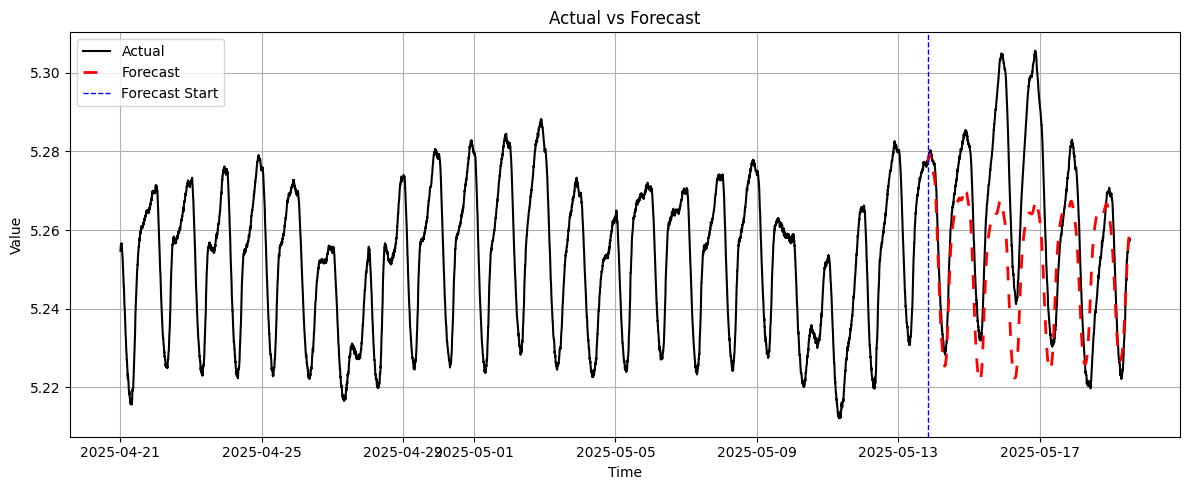

In [12]:
plot_actual_vs_forecast(df['load'], forecast)

In [13]:
def find_best_ma_q(series, max_q=200):
    best_aic = float('inf')
    best_q = None
    best_model = None

    for q in range(1, max_q + 1):
        model = ARIMA(series, order=(0, 0, q))
        try:
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_q = q
                best_model = result
        except:
            continue  # skip failed models

    return best_q, best_model

In [14]:
best_q, best_model = find_best_ma_q(train['load'], max_q=10)

D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\ML\EnergyPrediction\.venv\Lib\site-packages\s

In [17]:
forecast = best_model.forecast(steps=len(test))

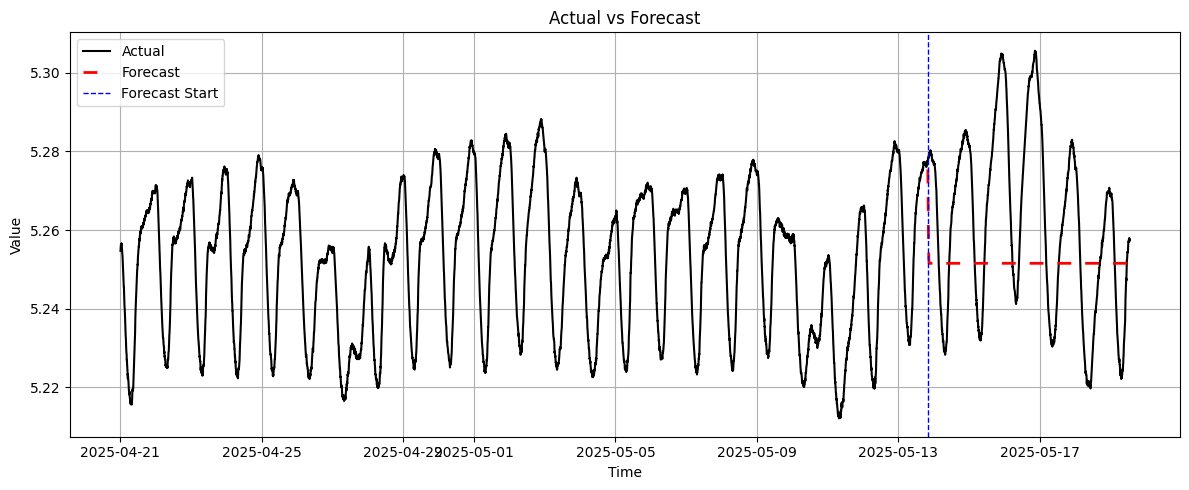

In [18]:
plot_actual_vs_forecast(df['load'], forecast)